# Grade: /100 pts
# Assignment 8: Customer Segmentation with Clustering

In this assignment, you will be solving a traditional problem in quantitative marketing: customer segmentation. Having a properly segmented database is extremely important to define marketing campaigns, as it allows companies to define value-centric actions targeted towards customers of different profiles. In this ocassion you are going to analyze customers of an automobile company.

Assume you are the owner of a consulting company that is in charge of this project. In this assignment you are going to conduct 2 different strategies for segmentating the potential customers.

The information is provided in the document `DATA.csv` which has the following columns:

- **ID:** Customer identifier (it does not have prediction power).
- **Gender:** Gender of a customer.
- **Ever_Married**: Potential customer's marrige status.
- **Age**: Potential customer's age.
- **Graduated:** Education status of the customer.
- **Profession:** Type of customer's career.
- **Work_Experience:** Work experience in years.
- **Spending_Score:** Level of customer's spending power.
- **Family_Size:** Number of family members for the customer.
- **Var_1:** Anonymised Category for the customer.


### Follow These Steps before submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline. 

5.  Your submission document should be saved in the form: `LastName_FirstName_Assignment9.ipynb`


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
# !pip install yellowbrick
#from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn import preprocessing
from sklearn.decomposition import PCA
import seaborn as sns
import itertools
%matplotlib inline

## Question 1 Loading the data and Preprocessing (10 pts)


1. Import the data. Report the data shape. How many null values in each column?

In [ ]:
data_raw = pd.read_csv('/content/DATA.csv');
print(data_raw.shape)
print(data_raw.isnull().sum(axis=0))

(8068, 10)
ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession           0
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
dtype: int64


2. For the column `Work_Experience` and `Family_Size`, use median value to replace the null values. For each of other columns with null entries, use the most frequent level in a column to replace the null values in this column.

In [ ]:

data_raw['Ever_Married'] = data_raw['Ever_Married'].fillna(data_raw['Ever_Married'].value_counts().index[0])
data_raw['Graduated'] = data_raw['Graduated'].fillna(data_raw['Graduated'].value_counts().index[0])
data_raw['Var_1'] = data_raw['Var_1'].fillna(data_raw['Var_1'].value_counts().index[0])
data_raw['Work_Experience'] = data_raw['Work_Experience'].fillna(data_raw['Work_Experience'].mean())
data_raw['Family_Size'] = data_raw['Family_Size'].fillna(data_raw['Family_Size'].mean())
print(data_raw.isnull().sum(axis=0))

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
dtype: int64


3. Using `preprocessing.OneHotEncoder()`, convert all categorical features. Make sure not to add collinear features during the encoding process. Then, display the first 10 rows.

In [ ]:

enc = preprocessing.OneHotEncoder(drop='first')
enc.fit(data_raw[['Gender','Graduated','Profession','Spending_Score', 'Ever_Married','Var_1']])
hot_enc = enc.transform(data_raw[['Gender','Graduated','Profession','Spending_Score', 'Ever_Married','Var_1']]).toarray()
data = pd.concat([data_raw, pd.DataFrame(hot_enc,columns=enc.get_feature_names_out())], 1).drop(['Gender','Graduated','Profession','Spending_Score', 'Ever_Married','Var_1'],1)
data[:10]

<ipython-input-4-a1a86a8cf6a1>:4: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data = pd.concat([data_raw, pd.DataFrame(hot_enc,columns=enc.get_feature_names_out())], 1).drop(['Gender','Graduated','Profession','Spending_Score', 'Ever_Married','Var_1'],1)
<ipython-input-4-a1a86a8cf6a1>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = pd.concat([data_raw, pd.DataFrame(hot_enc,columns=enc.get_feature_names_out())], 1).drop(['Gender','Graduated','Profession','Spending_Score', 'Ever_Married','Var_1'],1)


,ID,Age,Work_Experience,Family_Size,Gender_Male,Graduated_Yes,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Healthcare,...,Profession_Other,Spending_Score_High,Spending_Score_Low,Ever_Married_Yes,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,462809,22,1.000000,4.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,462643,38,2.641663,3.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,466315,67,1.000000,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,461735,67,0.000000,2.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,462669,40,2.641663,6.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5,461319,56,0.000000,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6,460156,32,1.000000,3.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,464347,33,1.000000,3.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,465015,61,0.000000,3.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
9,465176,55,1.000000,4.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


4. Then standardize your data (except the `ID` column) with `StandardScaler()`, and store the result into a Pandas dataFrame.

In [ ]:
scalar = StandardScaler().fit(data.drop('ID',1))
standard_data = scalar.transform(data.drop('ID',1))
data = pd.DataFrame(standard_data, columns = scalar.get_feature_names_out())

<ipython-input-5-3059a74a4175>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  scalar = StandardScaler().fit(data.drop('ID',1))
<ipython-input-5-3059a74a4175>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  standard_data = scalar.transform(data.drop('ID',1))


## Question 2: First Strategy (45 pts)

1. We use K-means method to conduct the clustering analysis by setting the seed to 9. Use the [KelbowVisualizer](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) function to find the optimal number of clusters, where sets `k=(2,10)` and `metric` as default. **Written answer: Can you find the optimal number of clusters using the elbow method?**

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=9), k=(2, 10))

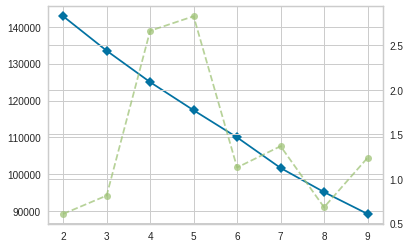

In [ ]:
model = KMeans()
elb_vizualizer  = KElbowVisualizer(model, k=(2,10))
elb_vizualizer.fit(data)

**Written answer (2 pts):**
No you can't really tell the optimal number of clusters as there is no clear point where adding clusters has a significant drop mostly as adding clusters  decreases distortion score at a consistent rate

2. Try between 2 and 6 clusters, using a seed of 9, and draw the silouhette plot for the K-means analysis. Report the silhouette scores. Do NOT use the built-in function `SilhouetteVisualizer()`.

For n_clusters = 2 The average silhouette_score is : 0.13158115680973947
For n_clusters = 3 The average silhouette_score is : 0.14408372629386737
For n_clusters = 4 The average silhouette_score is : 0.13588016256646918
For n_clusters = 5 The average silhouette_score is : 0.14524592895001226
For n_clusters = 6 The average silhouette_score is : 0.1553838461473155


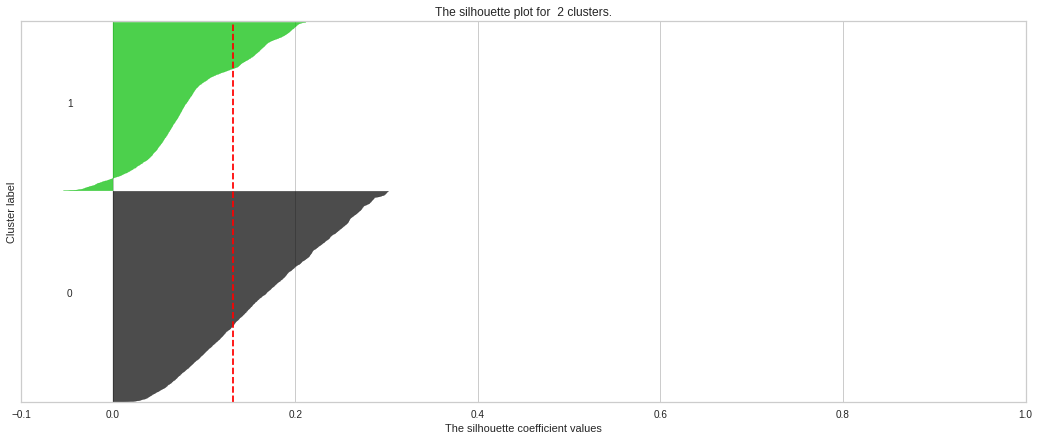

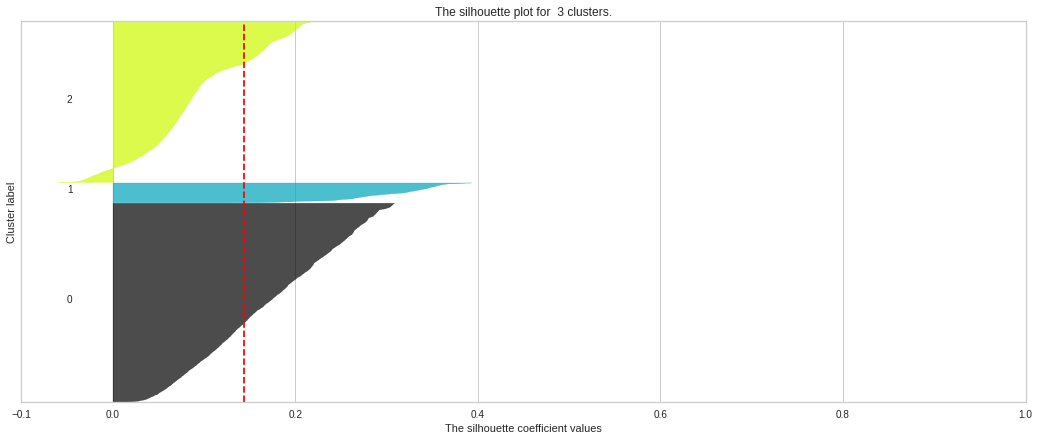

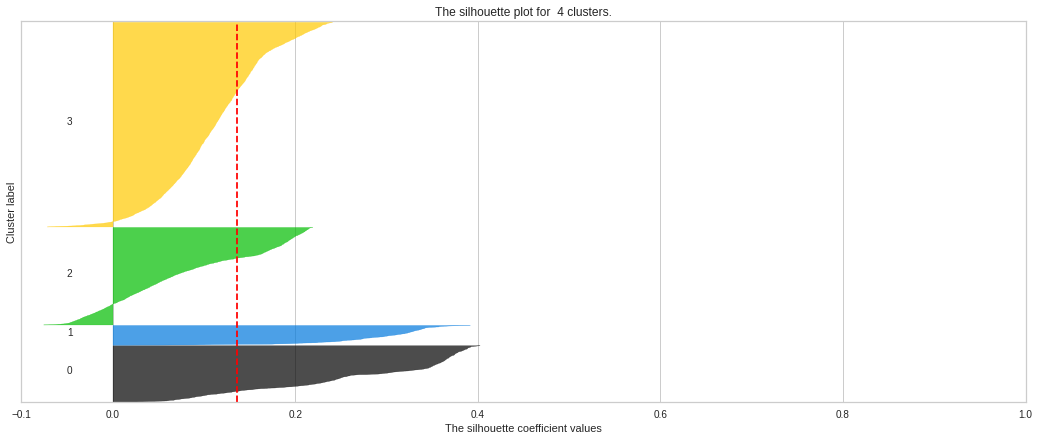

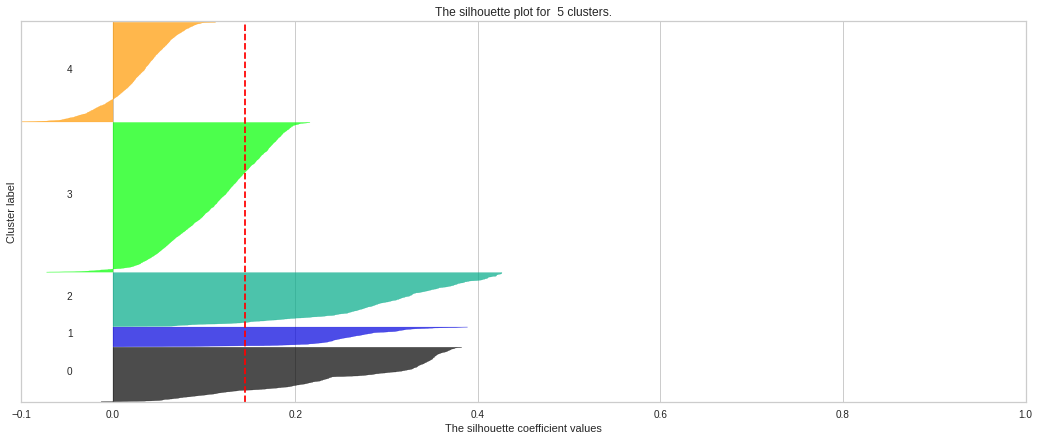

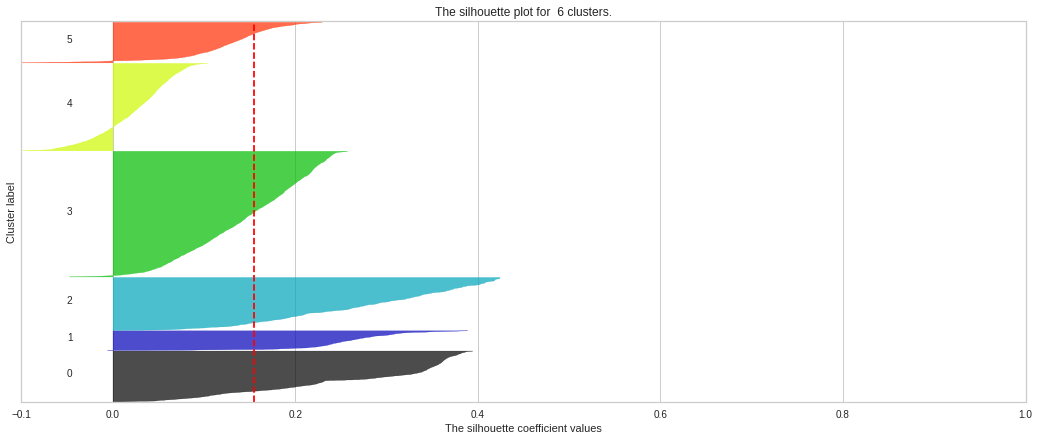

In [ ]:
k_value = list(range(2,7))
#Acquired and modified from sklearn
for n_clusters in k_value:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for  "+ str(n_clusters) +" clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

**What is the optimal number of clusters using the silhouette method?**



**ANSWER HERE (2pts):** 
The sillhoute shows that the optimal number is 6 as it has the highest score

3. Use the first and second principle components of the data as the x and y axis, draw the scatter plot where points are differentiated by clusters. Hints: you need to first perform dimension reduction with PCA using 2 components.

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


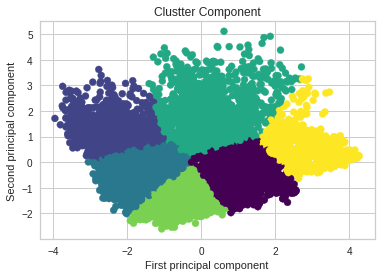

[1 3 0 ... 4 2 3]


In [ ]:
x = PCA(n_components= 2).fit_transform(data)
km = KMeans(n_clusters=6, random_state= 9,).fit_predict(x)

plt.scatter(x[:,0], x[:,1], c=km, cmap='viridis')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Clustter Component')
plt.show()
print(km)


4. The objective of any cluster analysis over customer data is to create a reasonable segmentation of your customers. Using the number of clusters you have decided in Question 1, create a table (using `pandas.DataFrame.groupby`) of the averages per variable (`Age`, `Work_Experience`, `Family_Size`) of each cluster (use the original, non-scaled, variables). Write a conclusion on the characteristics of each cluster.

In [ ]:
compare = data_raw[['Age','Work_Experience','Family_Size']]
compare.loc[:,'cluster'] = km
print(compare[0:5])
compare.groupby('cluster')[['Age','Work_Experience','Family_Size']].mean()

   Age  Work_Experience  Family_Size  cluster
0   22         1.000000          4.0        1
1   38         2.641663          3.0        3
2   67         1.000000          1.0        0
3   67         0.000000          2.0        5
4   40         2.641663          6.0        0


<ipython-input-9-dbef98ab0074>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare.loc[:,'cluster'] = km


,Age,Work_Experience,Family_Size
cluster,,,
0,52.793499,2.320092,2.472470
1,27.463682,2.453955,3.985779
2,29.257740,2.804560,3.255542
3,46.044944,2.297809,3.268283
4,38.339915,4.005694,1.872501
5,63.724622,1.751556,2.799301


**ANSWER HERE (2pts):** 
Clustter 0 is probably single child parents

*   clustter 0 is probably single child parents
*   clustter 1 is probably retired couples with a child
*   cluster 2 is a family of four 
*   cluster 3 is chidless middle aged couples
*   cluster 4 is older families of 3-4
*   cluster 5 can be single or a couple that are still in the workfield

 




## Question 3: Second Strategy (45 pts) 

1. First performing dimension reduction with PCA using 4 components. Look for the best number of clusters (between 3 to 6) using `Agglomerative clustering` with `affinity = 'cosine'` and `linkage = 'average'` and Silhuoette analysis.

In [ ]:
x = PCA(n_components= 4).fit_transform(data)
sil_score = []
for k in k_value:
  ag_clust = AgglomerativeClustering(n_clusters=k,metric='cosine', linkage = 'average').fit_predict(x)
  print('Number of Clustters: ', k)
  print("Silhouette Score: ", silhouette_score(x, ag_clust))

Number of Clustters:  2
Silhouette Score:  0.22355124504121662
Number of Clustters:  3
Silhouette Score:  0.2544479230627813
Number of Clustters:  4
Silhouette Score:  0.26857703244396086
Number of Clustters:  5
Silhouette Score:  0.23231960243950417
Number of Clustters:  6
Silhouette Score:  0.2199784779884159


**Written Answer:** How many clusters is select based on the previous results?

**ANSWER HERE (2pts):** 
4 clustters as this has the highest sil score

2. Graph the scatter plot of the PCA-transformed data differentiated by cluster. Use the first and second principal components of the data as the x and y axis.


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


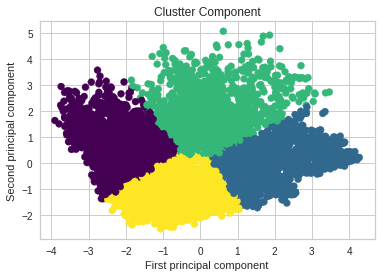

In [ ]:
x = PCA(n_components= 2).fit_transform(data)
km = KMeans(n_clusters=4, random_state= 9,).fit_predict(x)

plt.scatter(x[:,0], x[:,1], c=km, cmap='viridis')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Clustter Component')
plt.show()


3. Make the boxplot `Age` vs `Family_Size` based on the dataFrame before standardization, and use `hue = "Your_Cluster_Label"` in the plot function to show the differences among clusters.

<ipython-input-12-153093daaa42>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare.loc[:,'cluster'] = km


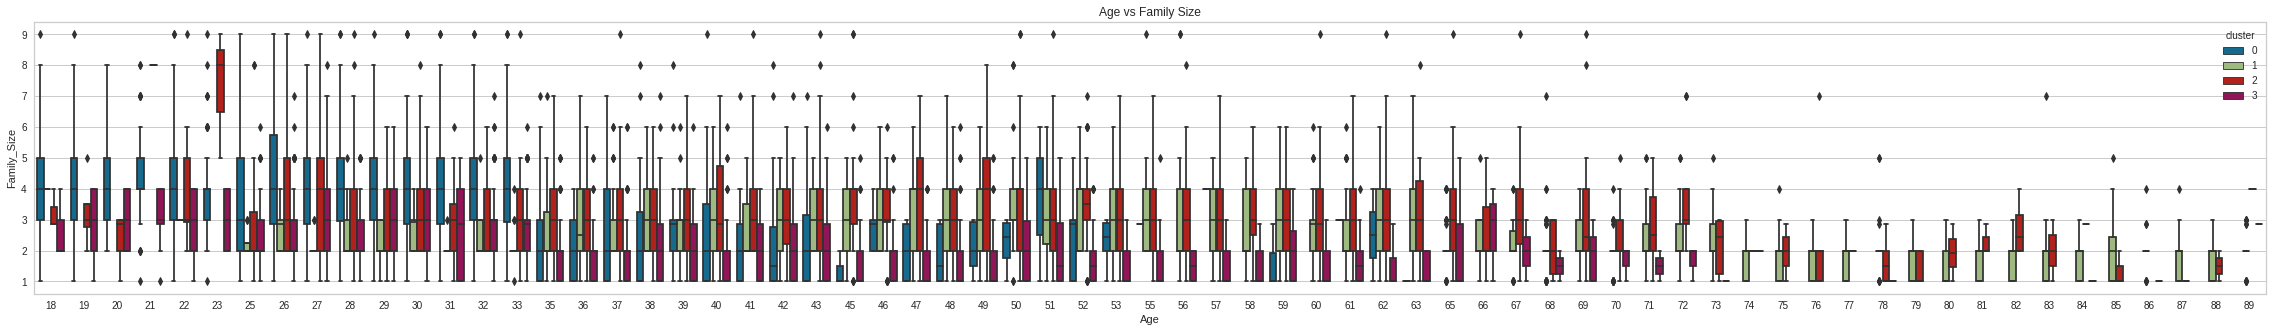

In [ ]:

compare = data_raw[['Age','Work_Experience','Family_Size']]
compare.loc[:,'cluster'] = km
fig, ax = plt.subplots(figsize=(40, 5))

sns.boxplot(x='Age', y='Family_Size', data=compare, ax=ax, hue = compare['cluster'])
plt.title('Age vs Family Size')

plt.show()

4. Using the number of clusters you have decided in Question 2 and `pandas.DataFrame.groupby`, create a table of the averages per variable (`Age`, `Work_Experience`, `Family_Size`) of each cluster (use the original, non-scaled, variables). Write a conclusion on the characteristics of each cluster.

In [ ]:
compare.groupby('cluster')[['Age','Work_Experience','Family_Size']].mean()


,Age,Work_Experience,Family_Size
cluster,,,
0,27.788684,2.554311,3.703789
1,57.270630,2.075642,2.660191
2,46.251980,2.285661,3.278731
3,38.441841,3.517437,2.185591


**ANSWER HERE (2pts):** 
The first cluster seems to be from people in families under 4 people that have a partner and maybe one or two child, the second seems to be of older couples with max one child, while the third single child families, while the last is childless couples